# Deep Cache with MediSynDataset

### Reference Paper
> - Deep Cache: A Deep Learning Based Framework For Content Caching 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-cache-dataset2/mediSynDataset_x2_O3488.csv
/kaggle/input/deep-cache-dataset2/mediSynDataset_x2_O1042.csv
/kaggle/input/deep-cache-dataset2/y_pred-2.npy


In [2]:
# Use GPU if available, otherwise fall back to CPU
import tensorflow as tf

device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(device)

2025-06-04 05:16:19.144023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749014179.322280      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749014179.373365      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/GPU:0


In [3]:
# Load data
df = pd.read_csv('/kaggle/input/deep-cache-dataset2/mediSynDataset_x2_O3488.csv') 
df

,object_ID,request_time
0,2033,8.641616e+04
1,1280,8.641938e+04
2,3482,8.642676e+04
3,2764,8.642905e+04
4,2698,8.643068e+04
...,...,...
39088106,2574,3.673981e+06
39088107,2312,3.673981e+06
39088108,2785,3.673981e+06
39088109,2663,3.673981e+06


## Split data
- To align with the paper's goal which is predicting the future characteristics of an object based on past logs, we split the dataset into 60% for training and 40% for evaluation.

In [4]:
# Split into train/test before pivot
cut_idx = int(len(df) * 0.6)
train_df = df.iloc[:cut_idx].reset_index(drop=True)
test_df = df.iloc[cut_idx:].reset_index(drop=True)

## Feature Engineering
> "The probability of $o^i$ is the normalized frequency of that object in an hour."

In [5]:
# Create 'hour' column
train_df['hour'] = train_df['request_time'] // 3600
test_df['hour'] = test_df['request_time'] // 3600

# Unique object list (shared across both sets)
object_ids = df['object_ID'].unique()
object_ids.sort()

# Pivot (hour, object) → count table
train_pivot = train_df.groupby(['hour', 'object_ID']).size().unstack(fill_value=0)
train_pivot = train_pivot.reindex(columns=object_ids, fill_value=0)

test_pivot = test_df.groupby(['hour', 'object_ID']).size().unstack(fill_value=0)
test_pivot = test_pivot.reindex(columns=object_ids, fill_value=0)

# Normalize
train_probs = train_pivot.div(train_pivot.sum(axis=1), axis=0).fillna(0)
test_probs = test_pivot.div(test_pivot.sum(axis=1), axis=0).fillna(0)

In [6]:
m, k = 20, 26 # Sequence length for input(m) and output(k)

# Helper function to create sliding window sequences
def create_sequences(prob_df, m, k):
    X, y = [], []
    for i in range(len(prob_df) - m - k):
        x_seq = prob_df.iloc[i:i+m].values  # (m, d)
        y_seq = prob_df.iloc[i+m:i+m+k].values  # (k, d)
        X.append(x_seq)
        y.append(y_seq)
    X = np.array(X)
    y = np.array(y)
    
    # Reshape: (samples * d, m, 1), (samples * d, k, 1)
    X = X.transpose(0, 2, 1).reshape(-1, m, 1)
    y = y.transpose(0, 2, 1).reshape(-1, k, 1)
    return X, y

# Create train and test sets
X_train, y_train = create_sequences(train_probs, m, k)
X_test, y_test = create_sequences(test_probs, m, k)

print("Train X shape:", X_train.shape)
print("Train y shape:", y_train.shape)
print("Test X shape:", X_test.shape)
print("Test y shape:", y_test.shape)

Train X shape: (717236, 20, 1)
Train y shape: (717236, 26, 1)
Test X shape: (245091, 20, 1)
Test y shape: (245091, 26, 1)


## Build LSTM Model 
> "For our datasets, we use a two-layer depth LSTM Encoder-Decoder model with 128 and 64 as the number of hidden units. ... The loss function is chosen as mean-squared-error (MSE). We ran our experiments for a number of epochs equal to 30, with the batch size set to 10% of the training data."
- Batch size was reduced to 64 due to limited memory capacity.

In [7]:
from tensorflow.keras.layers import (
    Input, LSTM, Dense, TimeDistributed, RepeatVector,
    Dropout, Bidirectional, Attention, Concatenate
)
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

In [8]:
def build_seq2seq_model(m, k):
    # ----- Encoder -----
    encoder_inputs = Input(shape=(m, 1))  # Input shape: (sequence_length, 1)

    # Two-layer encoder with 128 and 64 hidden units
    encoder_lstm_1 = LSTM(128, return_sequences=True)
    encoder_lstm_2 = LSTM(64, return_state=True)

    x = encoder_lstm_1(encoder_inputs)
    encoder_outputs, state_h, state_c = encoder_lstm_2(x)
    encoder_states = [state_h, state_c]  # Final encoder states passed to decoder

    # ----- Decoder -----
    decoder_inputs = RepeatVector(k)(encoder_outputs)  # Repeat context vector for k time steps

    # Two-layer decoder with 128 and 64 hidden units
    decoder_lstm_1 = LSTM(128, return_sequences=True)
    decoder_lstm_2 = LSTM(64, return_sequences=True)

    x = decoder_lstm_1(decoder_inputs, initial_state=encoder_states)
    decoder_outputs = decoder_lstm_2(x)

    # Predict one value per time step
    decoder_dense = TimeDistributed(Dense(1))
    output_seq = decoder_dense(decoder_outputs)

    # Compile the model with MSE loss and MAE metric
    model = Model(encoder_inputs, output_seq)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

In [9]:
model = build_seq2seq_model(m, k)
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.1)

I0000 00:00:1749014228.392370      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/30


I0000 00:00:1749014236.619015      57 cuda_dnn.cc:529] Loaded cuDNN version 90300


10087/10087 ━━━━━━━━━━━━━━━━━━━━ 121s 11ms/step - loss: 1.9078e-05 - mae: 0.0014 - val_loss: 9.3681e-07 - val_mae: 8.5958e-04
Epoch 2/30
10087/10087 ━━━━━━━━━━━━━━━━━━━━ 112s 11ms/step - loss: 6.8781e-06 - mae: 7.6295e-04 - val_loss: 2.8956e-07 - val_mae: 3.2448e-04
Epoch 3/30
10087/10087 ━━━━━━━━━━━━━━━━━━━━ 114s 11ms/step - loss: 6.0699e-06 - mae: 6.6786e-04 - val_loss: 3.0885e-07 - val_mae: 2.9428e-04
Epoch 4/30
10087/10087 ━━━━━━━━━━━━━━━━━━━━ 113s 11ms/step - loss: 5.3038e-06 - mae: 6.1146e-04 - val_loss: 3.0956e-07 - val_mae: 3.6102e-04
Epoch 5/30
10087/10087 ━━━━━━━━━━━━━━━━━━━━ 113s 11ms/step - loss: 5.4101e-06 - mae: 5.6738e-04 - val_loss: 3.4402e-07 - val_mae: 4.2384e-04
Epoch 6/30
10087/10087 ━━━━━━━━━━━━━━━━━━━━ 114s 11ms/step - loss: 5.0625e-06 - mae: 5.3684e-04 - val_loss: 4.2059e-07 - val_mae: 3.9345e-04
Epoch 7/30
10087/10087 ━━━━━━━━━━━━━━━━━━━━ 115s 11ms/step - loss: 5.4369e-06 - mae: 5.4990e-04 - val_loss: 3.1503e-07 - val_mae: 3.5728e-04
Epoch 8/30
10087/10087 ━━━━━

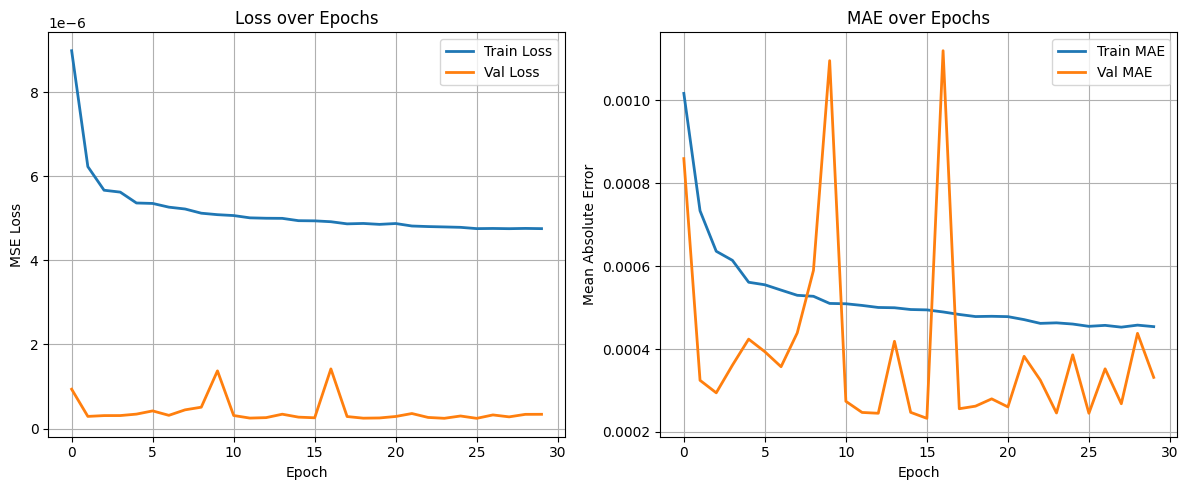

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation loss/MAE
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss over Epochs')
plt.grid(True)
plt.legend()

# MAE plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Val MAE', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('MAE over Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
# Predic and Validate
y_pred = model.predict(X_test)
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Evaluation — Loss (MSE): {loss:.10f}, MAE: {mae:.10f}")

print("Prediction Shape:", y_pred.shape)

7660/7660 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step

Test Evaluation — Loss (MSE): 0.0000006452, MAE: 0.0003513322
Prediction Shape: (245091, 26, 1)


In [12]:
np.save("y_pred.npy", y_pred)

In [13]:
# y_pred = np.load("/kaggle/input/deep-cache-dataset2/y_pred-2.npy")

## Cache Policy Setting
> "For dataset 2, we rather consider a varying number of top M objects with the highest probability from multiple time intervals. In other words, our fake set of requests Ft not only considers immediate future, but also considers popular objects in the next 12 hours and 24 hours with a diminishing weight for the number of selected objects from each interval."
- To set different top-M values for different future time intervals, we used top 5 objects from 1 hour ahead, 4 from 12 hours, 3 from 24 hours.

In [14]:
# Set different top-M values for different future time intervals
# Top 5 objects from 1 hour ahead, 4 from 12 hours, 3 from 24 hours
M1, M2, M3 = 5, 4, 3  

top_objects_each_t = []  
for i in range(len(y_pred)):
    top_all = []
    
    # Check three specific future time steps: 0 (1 hour), 11 (12 hours), 23 (24 hours)
    for t, M in zip([0, 11, 23], [M1, M2, M3]):
        if t >= y_pred.shape[1]:
            continue  # Skip if prediction is shorter than the required time step

        next_probs = y_pred[i, t].flatten()  # Predicted probabilities for time step t
        top_indices = next_probs.argsort()[-M:][::-1]  # Get top-M object indices with highest probability
        top_all.extend(top_indices)

    top_objects_each_t.append(top_all)  # Store the deduplicated list of top objects

## Integral Operator
> "The operator is a simple merge operator, where the actual object request is followed by all the fake requests generated by our Caching Policy. This helps us to update the state of the cache by prefetching objects based on future object popularity and evict unpopular ones."

In [15]:
cut_idx = int(len(df) * 0.6)
test_df = df.iloc[cut_idx:].reset_index(drop=True)

In [16]:
# Merge real requests and fake requests
merged_requests = []
fake_insert_idx = 0
insert_interval = 10

actual_requests = test_df.sort_values('request_time')['object_ID'].tolist()

for t, req in enumerate(actual_requests):
    merged_requests.append(req)
    if fake_insert_idx < len(top_objects_each_t) and t % insert_interval == 0:
        fake_objs = top_objects_each_t[fake_insert_idx]
        merged_requests.extend(fake_objs)
        fake_insert_idx += 1

## Deep Cache vs Traditional LRU
> "We compare traditional LRU with Deep Cache, and without Deep Cache."

In [17]:
# LRU Cache simulator
from collections import OrderedDict

class LRUCache:
  def __init__(self, capacity):
    self.capacity = capacity
    self.cache = OrderedDict()
    self.hit = 0
    self.miss = 0

  def request(self, obj_id):
    if obj_id in self.cache:
        self.cache.move_to_end(obj_id)
        self.hit += 1
        return 1
    else:
        self.miss += 1
        if len(self.cache) >= self.capacity:
            self.cache.popitem(last=False) 
        self.cache[obj_id] = True
        return 0

  def get_hit_ratio(self):
    total = self.hit + self.miss
    return self.hit / total if total > 0 else 0

In [18]:
# Execute LRU with Deep Cache (on merged requests)
cache_size = 150
lru_deep = LRUCache(cache_size)
hits_deep = []
for obj_id in merged_requests:
    hit = lru_deep.request(obj_id)
    hits_deep.append(hit)

deep_cache_hit_ratio = round(lru_deep.get_hit_ratio(), 4)
print("DeepCache(LRU + 예측) 캐시 hit ratio:", deep_cache_hit_ratio)

DeepCache(LRU + 예측) 캐시 hit ratio: 0.3216


In [19]:
# Execute traditional LRU (on raw requests)
requests = actual_requests

lru_traditional = LRUCache(cache_size)
hits_trad = []
for obj_id in requests:
    hit = lru_traditional.request(obj_id)
    hits_trad.append(hit)

traditional_lru_hit_ratio = round(lru_traditional.get_hit_ratio(), 4)
print("LRU 캐시 hit ratio:", traditional_lru_hit_ratio)

LRU 캐시 hit ratio: 0.29


## Visualize the result

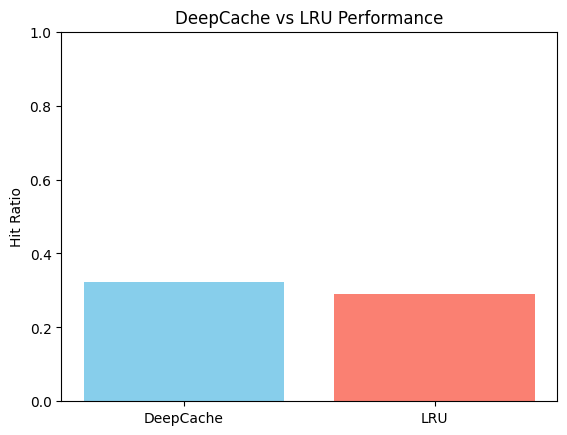

In [20]:
import matplotlib.pyplot as plt

ratios = [
    deep_cache_hit_ratio,
    traditional_lru_hit_ratio
]
labels = ['DeepCache', 'LRU']

plt.bar(labels, ratios, color=['skyblue', 'salmon'])
plt.ylabel('Hit Ratio')
plt.title('DeepCache vs LRU Performance')
plt.ylim(0, 1)
plt.show()

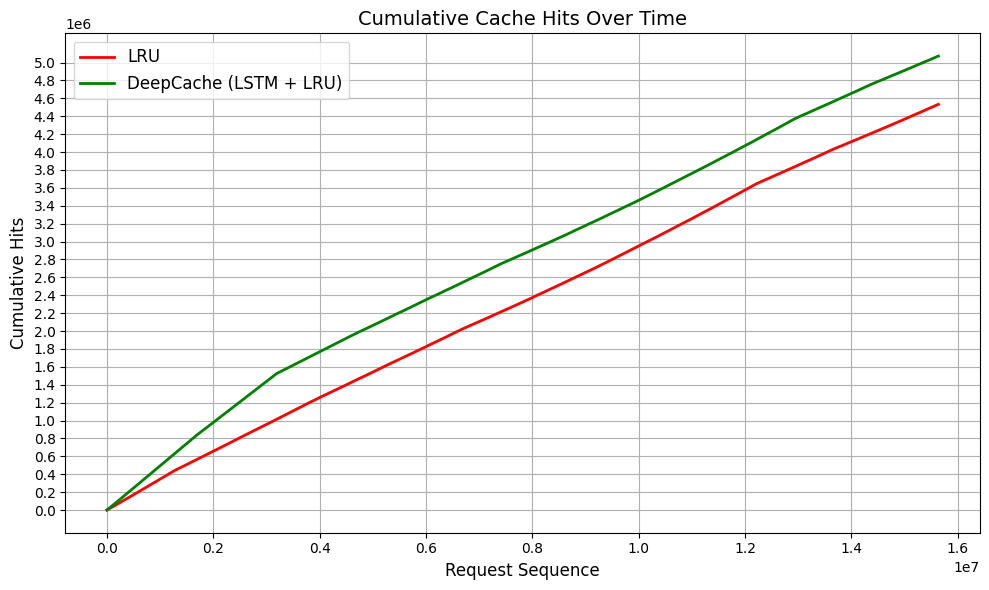

In [21]:
hits_deep = np.array(hits_deep, dtype=int)
hits_trad = np.array(hits_trad, dtype=int)

min_len = min(len(hits_trad), len(hits_deep))

hits_trad = hits_trad[:min_len]
hits_deep = hits_deep[:min_len]
x = np.arange(1, min_len + 1)

x = np.arange(1, len(hits_trad) + 1)
cumulative_deep = np.cumsum(hits_deep)
cumulative_trad = np.cumsum(hits_trad)

step = 10
x = np.arange(1, min_len + 1)[::step]
cumulative_trad = cumulative_trad[::step]
cumulative_deep = cumulative_deep[::step]

y_max = max(cumulative_deep.max(), cumulative_trad.max())
yticks = np.arange(0, y_max + 1, 200000)

plt.figure(figsize=(10, 6))
plt.plot(x, cumulative_trad, label='LRU', color='red', linewidth=2)
plt.plot(x, cumulative_deep, label='DeepCache (LSTM + LRU)', color='green', linewidth=2)
plt.xlabel('Request Sequence', fontsize=12)
plt.ylabel('Cumulative Hits', fontsize=12)
plt.title('Cumulative Cache Hits Over Time', fontsize=14)
plt.yticks(yticks, fontsize=10)  
plt.xticks(fontsize=10)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()